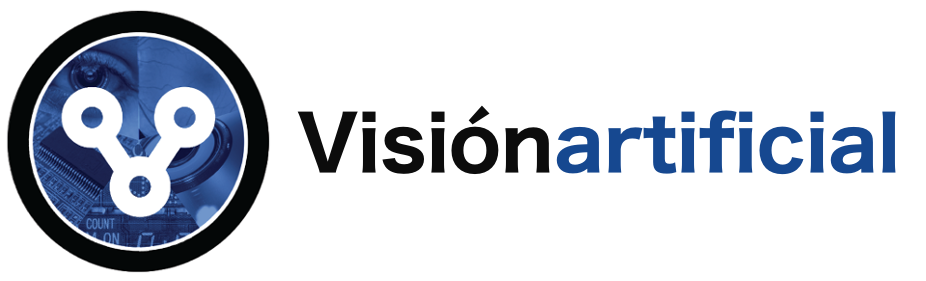

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />

# <font style="color:rgb(50,120,229)">Descriptor baseado momentos invariantes de Zernike</font>


Do mesmo xeito que os momentos de Hu, podemos utilizar os momentos de Zernike para caracterizar e cuantificar a forma dun obxecto nunha imaxe. Tamén de forma similar aos momentos de Hu, a forma dunha imaxe que queremos describir pode ser o contorno (é dicir, "borde") da forma ou unha máscara (é dicir, "área") da forma que queremos describir. Na maioría das aplicacións reais, é común usar a área xa que é menos susceptible ao ruído.

Non obstante, a diferenza dos momentos de Hu, os de Zernike son descritores máis potentes e xeralmente máis precisos con moi pouco custo computacional adicional.

Como comentaremos máis adiante neste caderno, a razón pola que os momentos de Zernike adoitan ser máis poderosos é porque son **ortogonais**; isto significa que hai pouca ou ningunha redundancia de información entre os momentos.

Para utilizar e extraer Zernike Moments usaremos o paquete **mahotas**. Os momentos de Zernike non están dispoñibles en OpenCV.


## <font style="color:rgb(50,120,229)">Obxectivos</font>

Neste caderno faremos unha visión xeral do descritor de imaxes baseado nos momentos de Zernike.
     
     
## <font style="color:rgb(50,120,229)">Para que se empregan os momentos de Zernike?</font>     

Os momentos de Zernike é un descritor de imaxes usado para caracterizar a forma dun obxecto nunha imaxe. A forma a describir pode ser unha imaxe binaria segmentada ou o contorno do obxecto.

Na maioría das aplicacións é preferible utilizar a imaxe binaria segmentada en lugar de só o contorno xa que a imaxe binaria segmentada é menos susceptible ao ruído.



## <font style="color:rgb(50,120,229)">Como funcionan os momentos de Zernike?</font>   

Os momentos de Zernike foron introducidos, por primeira vez, por Teague no artigo [Image Analysis via General Theory of Moments de 1980](./artigos/Teague1979.pdf). Ata ese momento, os momentos de Hu eran os que se empregaban como descritores de formas.

O beneficio das funcións ortogonais é que non hai redundancia de información entre momentos, polo que son máis robustas e discriminativas que os Momentos de Hu, que se basean en simples derivacións estatísticas.

Afortunadamente, os polinomios de Zernike son ortogonais sobre un disco con raio r (especificado en coordenadas polares), polo que son aplicables á visión por ordenador e á descrición da forma:


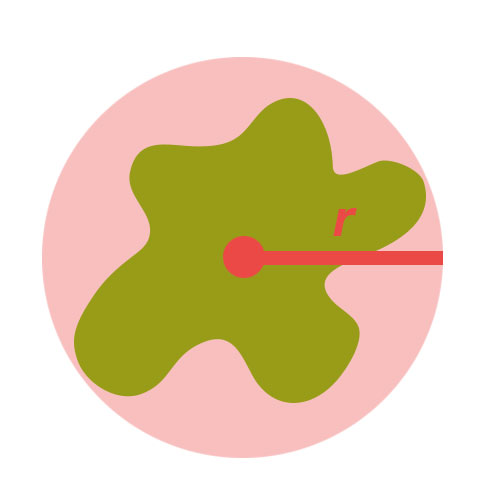

Na imaxe superior temos unha forma verde para a que queremos calcular os Momentos de Zernike. Despois colocamos un disco que rodea a nosa forma cun raio r. O raio r debería configurarse correctamente para incluír toda a rexión da forma, pero na práctica esta restrición normalmente relaxase para garantir que as imaxes se describan de forma coherente.

Para calcular os Momentos Zernike especificamos dous parámetros: o raio do disco e do grao do polinomio. O raio é a rexión da que se definen os polinomios.

En primeiro lugar, a imaxe de entrada mapease a un disco con raio r, onde o centro da imaxe está situado na orixe do disco. Os píxeles que quedan fóra do disco ignóranse e non se inclúen no cálculo, así que asegúrate de escoller o teu raio con coidado.

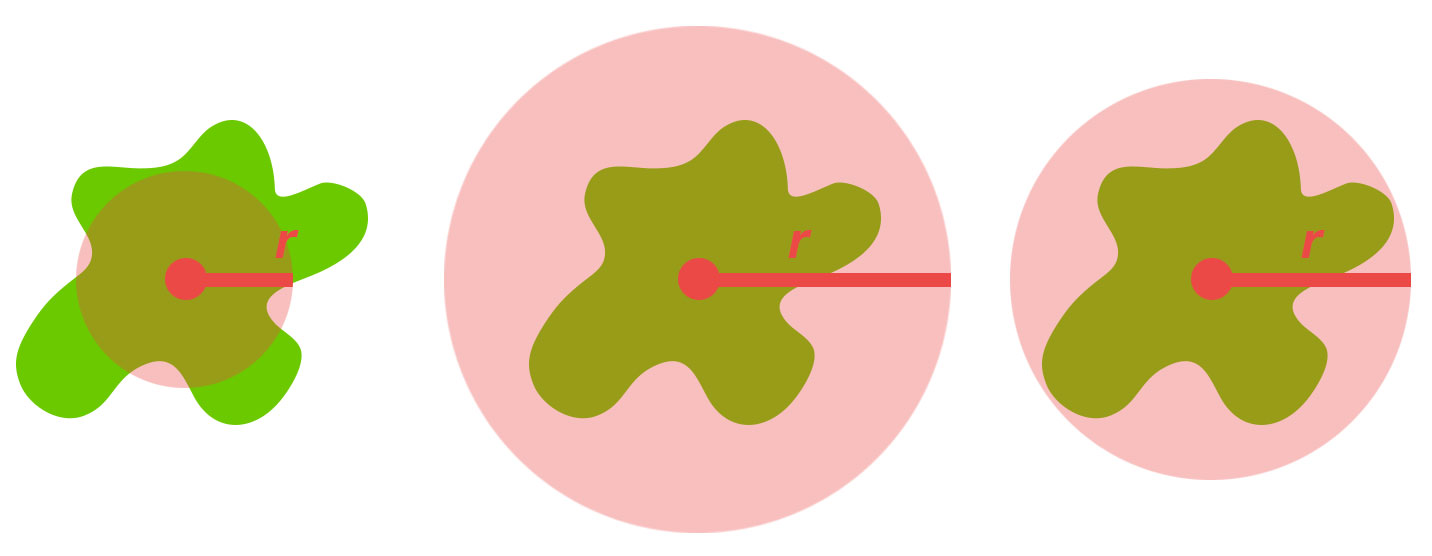

A partir de aí, os Momentos de Zernike ata o grao **d** son calculados e utilizados como vector de características. O tamaño do vector de características devolto está directamente controlado polo grao do polinomio. Canto maior sexa o grao, maior será o vector de características.

Unha revisión completa da formulación matemática dos momentos de Zernike está fóra do alcance deste caderno. Non obstante, se estás interesado en aprender máis sobre a formulación de polinomios de Zernike, asegúrate de buscar inforamción ao respecto.

## <font style="color:rgb(50,120,229)">Onde están implementados os momentos de Zernike?</font>

Os momentos de Zernike están implementado dentro do paquete mahotas Python.

## <font style="color:rgb(50,120,229)">Recoñecemento de obxectos en imaxes con momentos de Zernike</font>

Imos aprender a aplicar os Momentos de Zernike para recoñecer realmente un obxecto nunha imaxe. 

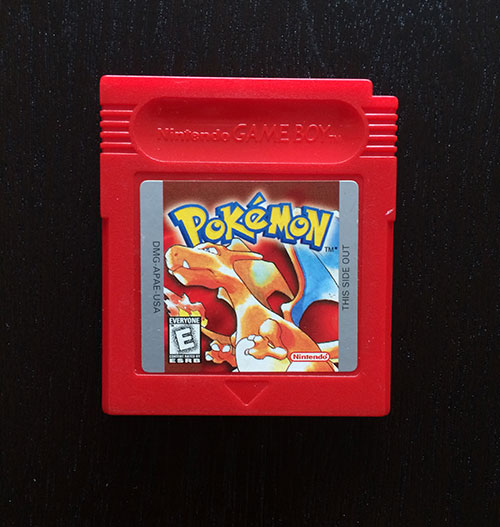
Neste tutorial necesitaremos dúas imaxes. A primeira imaxe será unha imaxe de referencia do obxecto que queremos detectar. A segunda imaxe será unha imaxe distractora que contén (1) o obxecto que queremos atopar e identificar e (2) un montón de obxectos "distractores" que significan "confundir" o noso algoritmo. O noso obxectivo será detectar con éxito a imaxe de referencia na segunda imaxe.

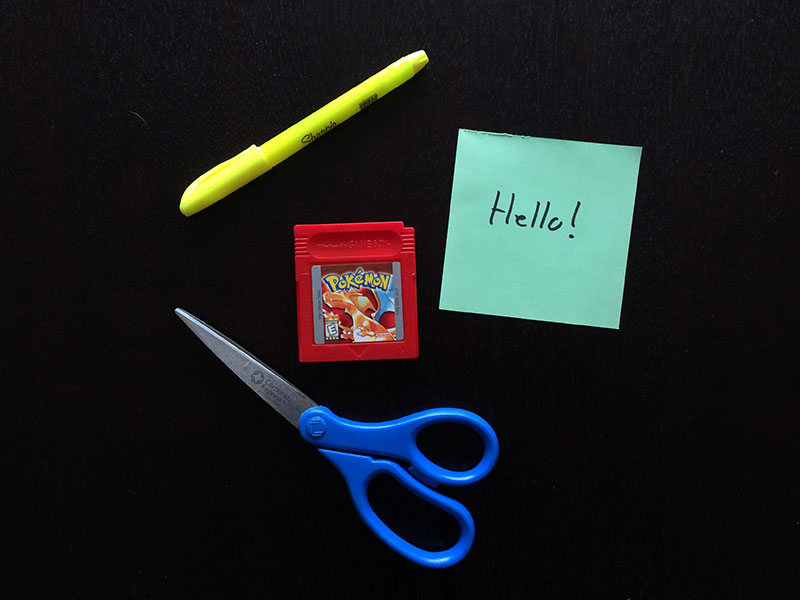

Nesta imaxe podemos ver que temos o cartucho do xogo Pokemon. Pero tamén ten unha morea de outros obxectos distractores, como tesoiras, un resaltador e unha nota adhesiva.

De novo, o noso obxectivo é poder detectar e recoñecer o cartucho do xogo Pokemon ignorando os outros obxectos distractores mediante o uso de descritores de Zernike Moments.

Entón, estás preparado para o reto?  imos comezar!

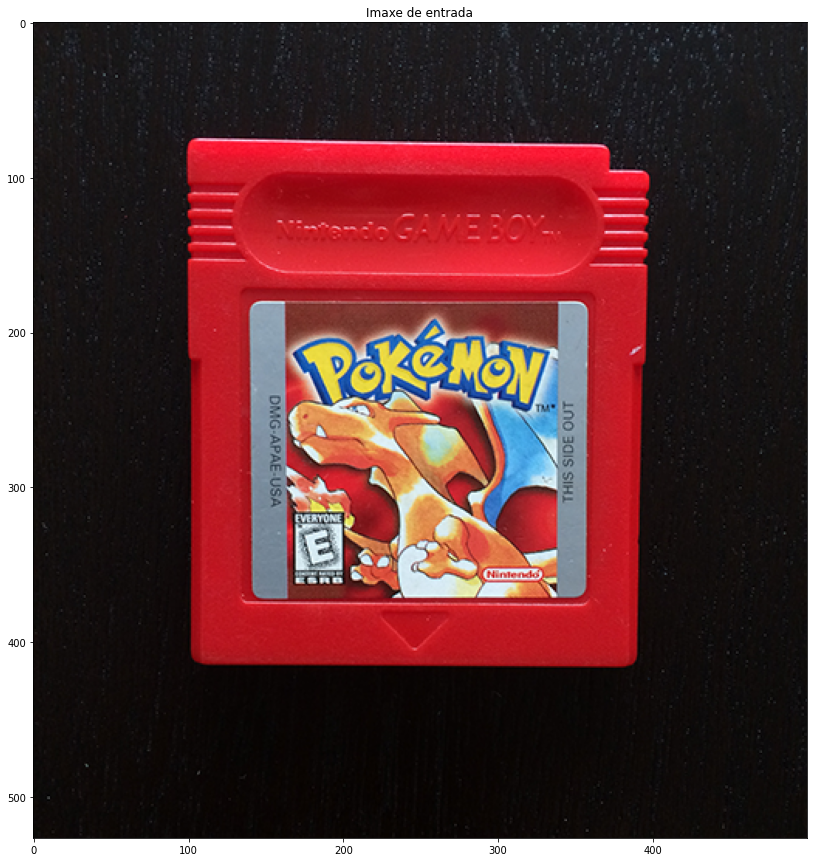

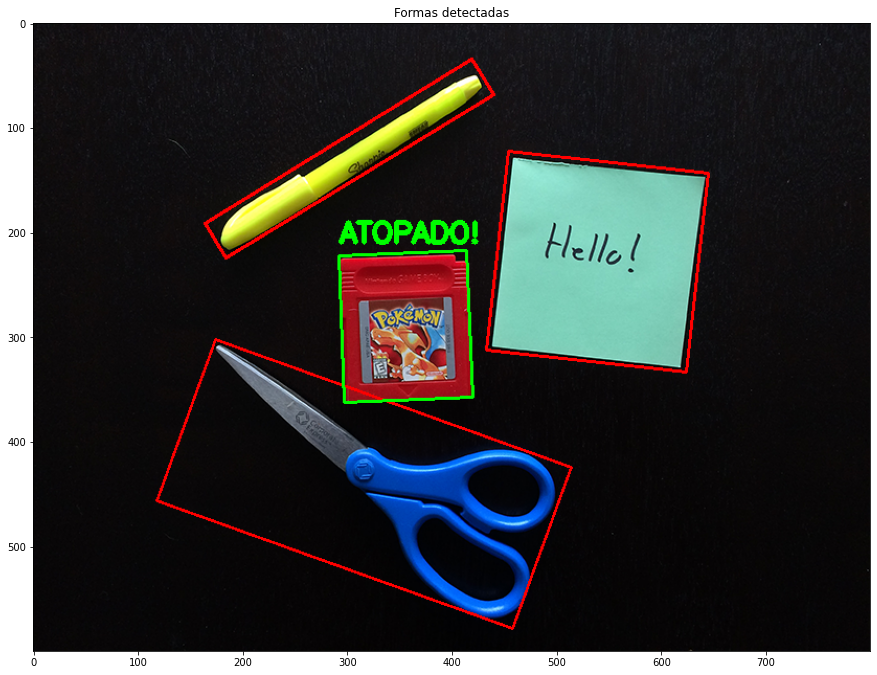

In [4]:
# Importacions estandar
import cv2
import numpy as np;
import imutils
from scipy.spatial import distance as dist
import mahotas #pip install mahotas==1.4.11
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
matplotlib.rcParams['image.cmap'] = 'gray'


def describe_shapes(image):
	# Inicializa as listas das caracteristicas de forma
	shapeFeatures = []

	# convertimos a iamxes a gris, suavizamos e aplicamos o limiar
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (13, 13), 0)
	thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]

	# realizamos unha serie de dilatacions para pechar ocos nas formas
	thresh = cv2.dilate(thresh, None, iterations=4)
	thresh = cv2.erode(thresh, None, iterations=2)

	# detectamos uns contornos
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)

	# lazo sobre todos os contornos
	for c in cnts:
		# creamos unha mascara e debuxamos os contornos
		mask = np.zeros(image.shape[:2], dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)

		# extraemos a imaxe ROI dende a mascara
		(x, y, w, h) = cv2.boundingRect(c)
		roi = mask[y:y + h, x:x + w]

		# acha os momentos de Zernike para a ROI e actualzia o lista do descritores de forma
		features = mahotas.features.zernike_moments(roi, cv2.minEnclosingCircle(c)[1], degree=8)
		shapeFeatures.append(features)

	# devolvemos a tupla de contornos e descritores de forma
	return (cnts, shapeFeatures)

# Cargamos o template do obxecto que queremos detectar e atopamola
# na zona da rexion do xogo onde queremos atopala
refImage = cv2.imread("./dataset/pokemon_red.png")
if refImage is None:
	print("imaxe non atopada")
(_, gameFeatures) = describe_shapes(refImage)

# cargamos a imaxe e describimolas
shapesImage = cv2.imread("./dataset/shapes.png")
if shapesImage is None:
	print("imaxe non atopada")
(cnts, shapeFeatures) = describe_shapes(shapesImage)

# Distancias as distancias Euclidean entre o video do xogo e todas as formas
# na segunda imaxe e enton atopamos o indice de menos distanica
D = dist.cdist(gameFeatures, shapeFeatures)
i = np.argmin(D)

# lazo sobre os contonos nas formas da imaxe
for (j, c) in enumerate(cnts):
	# se o índice do contorno actual non e igual ao indice
	# contorno coa distancia máis pequena e despois debuxa
	# na imaxe de saída
	if i != j:
		box = cv2.minAreaRect(c)
		box = np.int0(cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box))
		cv2.drawContours(shapesImage, [box], -1, (0, 0, 255), 2)

# debuxamos unha caixa arredor do obxecto detectado
box = cv2.minAreaRect(cnts[i])
box = np.int0(cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box))
cv2.drawContours(shapesImage, [box], -1, (0, 255, 0), 2)
(x, y, w, h) = cv2.boundingRect(cnts[i])
cv2.putText(shapesImage, "ATOPADO!", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
	(0, 255, 0), 3)

# visualizamos os resutlados
plt.figure(figsize=[15,15])
plt.imshow(refImage[:,:,::-1]);plt.title("Imaxe de entrada");
plt.figure(figsize=[15,15])
plt.imshow(shapesImage[:,:,::-1]);plt.title("Formas detectadas");
